<a href="https://colab.research.google.com/github/ElmPartners/Public/blob/master/Cap_Gains_Decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Realize or Not To Realize?

The capital gains tax rate $\tau_0$ will be changing tomorrow to $\tau$.  You have some amount of homogenous unrealized gains $g_0$, and you want to know whether you should realize your gains now (or more generally what fraction should be realized), given that you also want to hold the optimal amount of the risky asset to horizon $T$, at which point you'll realize any additional gains and pay any taxes.  

We assume the risky asset $S$ follows a GBM with mean return $\mu$ and volatility $\sigma$, and that you have CRRA utility with elasticity $\gamma$.  $S$ also pays a dividend at rate $\delta$ which is taxed at $\tau_d$.  

As usual we want to optimize expected utility:

\begin{equation}
U(\theta,\kappa) =  \mathbb{E}[u(\hat{P}_T)] \tag{1}
\end{equation}

where:

\begin{equation}
u(w) = \begin{cases}
\frac{w^{1-\gamma} - 1}{1-\gamma}, & \gamma \neq 1 \\ \\
ln(w), & \gamma = 1 \tag{2}
\end{cases}
\end{equation}

\begin{equation}
\hat{P}_T = P_T - (\phi^+ +\alpha(1-\frac{T}{T_c})^+ \phi^-)\tau \tag{3}
\end{equation}

\begin{equation}
\phi = (1-\theta-\epsilon)g + P_T e^{(-\kappa\delta(1 - \tau_d) - (1-\kappa)(1-\tau_i)r)T} - P_0 \tag{4}
\end{equation}

\begin{equation}
\epsilon = \frac{1}{\kappa_0}((\kappa_0-\kappa)^+ - \kappa_0\theta)^+ \tag{5}
\end{equation}

\begin{equation}
P_T = P_0 e^{(\kappa(\mu - \delta\tau_d) + (1-\kappa)(1-\tau_i)r-\frac{1}{2}\kappa^2\sigma^2)T + \kappa\sigma Z_T} \tag{6}
\end{equation}

\begin{equation}
P_0 = 1 - (\theta + \epsilon) g \tau_0 \tag{7}
\end{equation}

Note:  $\epsilon$ is the amount of extra immediate gain realization (if any) additional to $\theta$ called for by rebalancing the risk asset from $\kappa_0$ to $\kappa$.  $\alpha$ is the multiple applied to the asset-value of a loss carryforward if received today, and $T_c$ is the time after which loss carryforwards have no asset value.





In [36]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as pyp


# Inputs
gamma = 2

g = 0.0
kappa_0 = 0.7
tau_0 = 0.5
tau_vec = np.array([0.5, 0.5, 0.5])
tau_prob = np.array([0.33, 0.33, 0.33])
tau_d = 0.5
tau_i = 0.5
alpha = 0.0
T_c = 20

r = 0.04
mu = 0.04
sigma = 0.18
delta = 0.0
T = 20

int_range = 5
int_step = 0.01
theta_step = 0.25
kappa_step = 0.01
g_step = 0.01
T_step = 1

In [37]:
# Some inline functions we need
u = lambda x: (np.power(x, 1-gamma) - 1) / (1 - gamma)
epsilon = lambda theta, kappa: (1 / kappa_0) * np.maximum(0, np.maximum(0, kappa_0 - kappa) - kappa_0 * theta )
P_0 = lambda theta, kappa: 1 - (theta + epsilon(theta, kappa)) * g * tau_0
phi = lambda theta, kappa, P: (1 - theta - epsilon(theta, kappa)) * g + P*np.exp((-kappa*delta*(1-tau_d) - (1-kappa)*(1-tau_i)*r)*T) - P_0(theta, kappa)
P_hat = lambda P, theta, kappa, tau:  P - (np.maximum(0, phi(theta, kappa, P)) + alpha*np.maximum(0,(1-(T/T_c)))*np.minimum(0, phi(theta, kappa, P))) * tau
P_T = lambda theta, kappa, z: P_0(theta, kappa) * np.exp((kappa*(mu-delta*tau_d) + (1-kappa)*(1-tau_i)*r - 0.5*pow(kappa, 2)*pow(sigma, 2))*T +
                                                  kappa*sigma*pow(T, 0.5)*z)

# And some data structures
z_size = int(2 * int_range/int_step + 1)
tau_size = len(tau_vec)
Z = np.ones((tau_size, 1)) @ np.linspace(-int_range, int_range, endpoint=True, num=z_size)[None, :]
tau = tau_vec[:, None] @ np.ones((1, z_size))
probs = tau_prob[:, None] * norm.pdf(Z)


In [38]:
def expected_util(x: np.array, optim: bool = False) -> float:
    # x[0] = theta
    # X[1] = kappa
    E_u = (u(P_hat(P_T(x[0], x[1], Z), x[0], x[1], tau)) * probs).sum() / probs.sum()

    return (-1 if optim else 1) * E_u

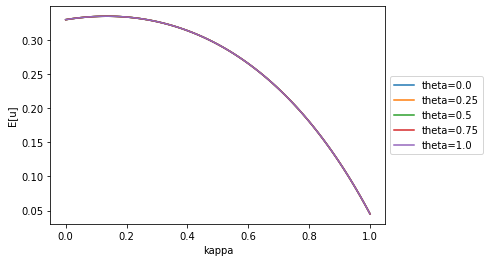

In [39]:
# The Main Event
# Plotting E[u] against kappa for different levels of theta
theta_vec = np.linspace(0, 1, endpoint=True, num=int(1/theta_step+1))
kappa_vec = np.linspace(0, 1, endpoint=True, num=int(1/kappa_step+1))
u_mat = np.zeros((len(theta_vec), len(kappa_vec)))

for i, theta in enumerate(theta_vec):
    for j, kappa in enumerate(kappa_vec):
        u_mat[i, j] = expected_util(np.asarray([theta, kappa]))

# Display
for i, theta in enumerate(theta_vec):
    pyp.plot(kappa_vec, u_mat[i, :], label='theta={}'.format(theta))
pyp.xlabel('kappa')
pyp.ylabel('E[u]')
pyp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyp.show()



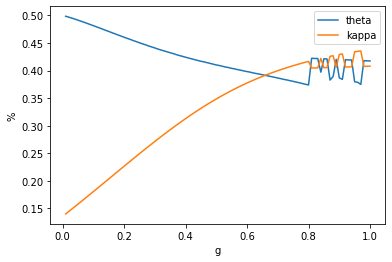

In [40]:
# The Main Event Pt II
# Plotting optimal theta and kappa against the amount of starting gain (g)

g_base = g
g_vec = np.linspace(g_step, 1, endpoint=True, num=int(1/g_step))
res_vec = np.zeros((2, g_vec.shape[0]))
bnds = [(0, 1), (0, 1)]
x0 = np.array([0.5, 0.5])
for i,g in enumerate(g_vec):
  res_vec[:, i] = minimize(expected_util, x0, args=(True), bounds=bnds).x
g = g_base
  
# Output
pyp.plot(g_vec, res_vec[0,:],label='theta')
pyp.plot(g_vec, res_vec[1,:],label='kappa')
pyp.xlabel('g')
pyp.ylabel('%')
pyp.legend()
pyp.show()


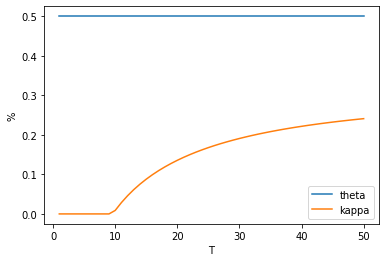

In [41]:
# The Main Event Pt III
# Plotting optimal theta and kappa against horizon

T_base = T
T_vec = np.linspace(T_step, 50, endpoint=True, num=int(50/T_step))
res_vec = np.zeros((2, T_vec.shape[0]))
bnds = [(0, 1), (0, 1)]
x0 = np.array([0.5, 0.5])
for i,T in enumerate(T_vec):
  res_vec[:, i] = minimize(expected_util, x0, args=(True), bounds=bnds).x
T = T_base
  
# Output
pyp.plot(T_vec, res_vec[0,:],label='theta')
pyp.plot(T_vec, res_vec[1,:],label='kappa')
pyp.xlabel('T')
pyp.ylabel('%')
pyp.legend()
pyp.show()

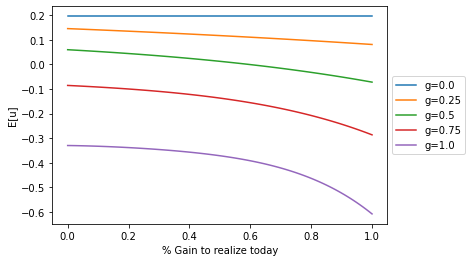

In [42]:
# The Main Event Pt IV
# Plotting E[u] vs. theta for fixed kappa
theta_vec = np.linspace(0, 1, endpoint=True, num=100)
g_vec = np.linspace(0, 1, endpoint=True, num=5)
kappa = 0.77
u_mat = np.zeros((len(theta_vec), len(g_vec)))

g_base = g
for j, g in enumerate(g_vec):
  for i, theta in enumerate(theta_vec):
    u_mat[i, j] = expected_util(np.asarray([theta, kappa]))
  pyp.plot(theta_vec, u_mat[:, j], label='g={}'.format(g))
g = g_base

# Display
pyp.xlabel('% Gain to realize today')
pyp.ylabel('E[u]')
pyp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
pyp.show()